In [383]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap

import importlib
import utils.gmm
import utils.metrics
import utils.priors
importlib.reload(utils.gmm)
importlib.reload(utils.metrics)
importlib.reload(utils.priors)
from utils.metrics import ClusteringMetrics
from utils.gmm import GaussianMixture

In [384]:
#device = 'cuda'
device = 'cpu'

init_params = 'kmeans'
n_features = 2
n_components = 4
random_state = 42
max_iter = 1000
np.random.seed(random_state)
torch.manual_seed(random_state)

n_samples_1 = 1000
n_samples_2 = 500
n_samples_3 = 200
n_samples_4 = 300
center_1 = np.array([0, 0])
center_2 = np.array([-4, 4])
center_3 = np.array([4, -4])
center_4 = np.array([4, 4])

C = np.array([[0.0, -0.5], [1.5, 0.5]])
C_2 = np.array([[0.0, 0.2], [0.4, 1.7]])
component_1 = np.dot(np.random.randn(n_samples_1, 2), C) + center_1
component_2 = 0.7 * np.random.randn(n_samples_2, 2) + center_2
component_3 = .5 * np.random.randn(n_samples_3, 2) + center_3
component_4 = np.dot(np.random.randn(n_samples_4, 2), C_2) + center_4

X = np.concatenate([component_1, component_2, component_3, component_4])

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.cat([torch.zeros(n_samples_1), torch.ones(n_samples_2), 2 * torch.ones(n_samples_3), 3 * torch.ones(n_samples_4)]).long()


## Experimental: Max Dist Method

## Using Priors

In [385]:
covariance_type = 'full'
random_state = 0
n_components = 4
n_features = 2
max_iter = 1000
init_params = 'kmeans'


def plot_gmm(gmm, X, labels_pred, ax=None, title='Gaussian Mixture', color='green'):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c='black', s=1, zorder=1)

    for n in range(gmm.n_components):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()
        
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        width, height = 2 * np.sqrt(vals) * 2
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=color, facecolor='none', lw=2, zorder=4)
        ax.add_patch(ellipse)

        ax.plot(mean[0], mean[1], 'o', color=color, markersize=5, zorder=5)

    ax.set_title(title)
    ax.axis('equal')

def plot_gmm_weights(gmm, X, labels_pred, ax=None, title='Gaussian Mixture', color='green', alpha=0.3):
    if ax is None:
        ax = plt.gca()
    
    ax.scatter(X.cpu().numpy()[:, 0], X.cpu().numpy()[:, 1], c='black', s=1, zorder=1, alpha=0.3)

    colors = ['red', 'blue', 'green', 'purple']
    for n, color in zip(range(gmm.n_components), colors):
        mean = gmm.means_[n].detach().cpu().numpy()
        
        if gmm.covariance_type == 'full':
            cov = gmm.covariances_[n].detach().cpu().numpy()
        elif gmm.covariance_type == 'tied':
            cov = gmm.covariances_.detach().cpu().numpy()
        elif gmm.covariance_type == 'diag':
            cov = np.diag(gmm.covariances_[n].detach().cpu().numpy())
        elif gmm.covariance_type == 'spherical':
            cov = np.eye(gmm.n_features) * gmm.covariances_[n].detach().cpu().numpy()
        
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

        width, height = 2* 2 * np.sqrt(vals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta,
                          edgecolor=color, facecolor=color, alpha=alpha[n], lw=2, zorder=2, label=f'Weight: {gmm.weights_[n].detach().cpu().numpy():.2f}')
        ax.add_patch(ellipse)

        ax.plot(mean[0], mean[1], '.', color=color, markersize=1, zorder=3)
        ax.legend(loc='upper right')

    ax.set_title(title)
    ax.axis('equal')

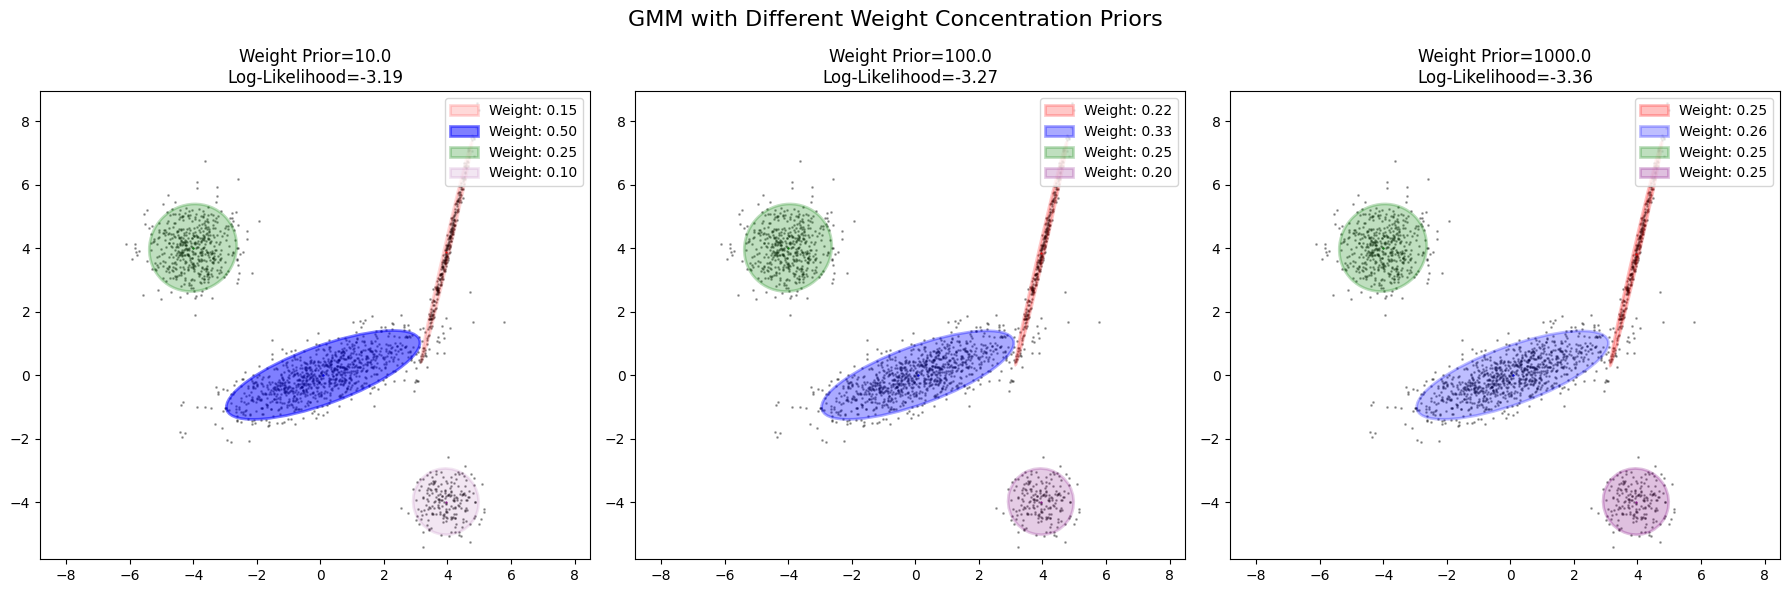

In [386]:
# Define the range of weight concentration priors
weight_concentration_values = [1, 1, 1, 1]
weight_concentration_prior = torch.tensor(weight_concentration_values, dtype=torch.float32)

# Prepare the plot grid
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('GMM with Different Weight Concentration Priors', fontsize=16)

for ax, i in zip(axs.ravel(), range(3)):
    weight_concentration_prior = torch.tensor(weight_concentration_values, dtype=torch.float32)*10**(i+1)
    # Create the GMM with a prior on the weights
    gmm_prior_weights = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type=covariance_type,
        max_iter=max_iter,
        init_params=init_params,
        weight_concentration_prior=weight_concentration_prior*i*10,
        random_state=random_state,
        device=device,
    )
    
    # Fit the GMM to the data
    gmm_prior_weights.fit(X_tensor)
    
    # Predict labels
    y_pred_prior_weights = gmm_prior_weights.predict(X_tensor).cpu().numpy()
    
    # Plot the results
    plot_gmm_weights(gmm_prior_weights, X_tensor, y_pred_prior_weights, ax=ax,
             title=f'Weight Prior={weight_concentration_prior.numpy()[0]}\nLog-Likelihood={gmm_prior_weights.lower_bound_:.2f}', color='blue', alpha=gmm_prior_weights.weights_.detach().cpu().numpy())

plt.tight_layout()
plt.savefig('figures/gmm_weight_prior.pdf', format='pdf', dpi = 400)
plt.show()


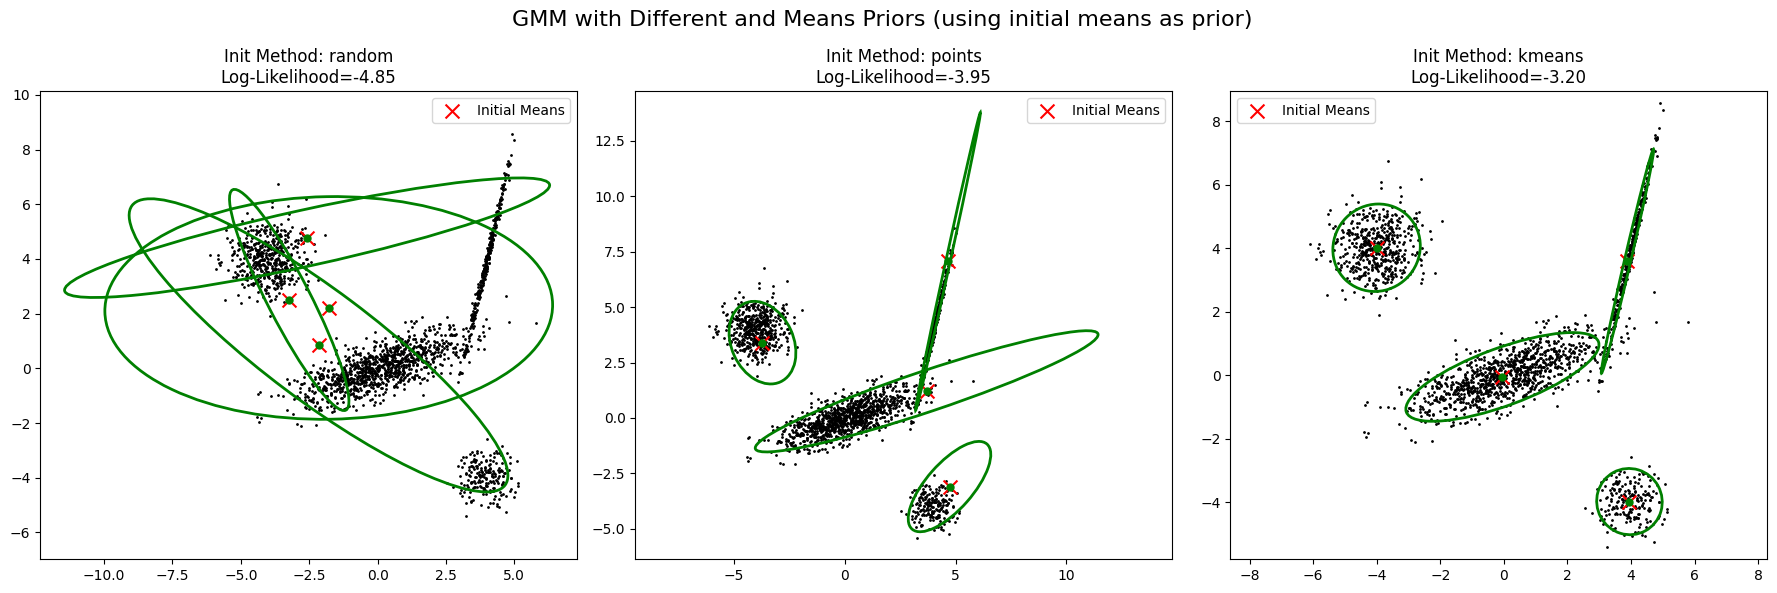

In [387]:
initialisation_methods = ['random', 'points', 'kmeans']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('GMM with Different Priors for the Means (using initial means as prior)', fontsize=16)

for ax, init_method in zip(axs.ravel(), initialisation_methods):
    # Initialize means using the selected method
    gmm_temp = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type=covariance_type,
        init_params=init_method,
        random_state=random_state,
        device=device
    )
    init_function = getattr(gmm_temp, f'_init_{init_method}')
    initial_means = init_function(X_tensor, n_components)
    mean_prior = initial_means.clone().detach().to(device)
    mean_precision_prior = 1e10

    # Create the GMM with a prior on the means
    gmm_prior_means = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type=covariance_type,
        max_iter=max_iter,
        init_params=init_method,
        mean_prior=mean_prior,
        mean_precision_prior=mean_precision_prior,
        random_state=random_state,
        device=device,
    )
    
    # Fit the GMM to the data
    gmm_prior_means.fit(X_tensor)
    
    # Predict labels
    y_pred_prior_means = gmm_prior_means.predict(X_tensor).cpu().numpy()
    
    # Plot the results
    plot_gmm(gmm_prior_means, X_tensor, y_pred_prior_means, ax=ax,
             title=f'Init Method: {init_method}\nLog-Likelihood={gmm_prior_means.lower_bound_:.2f}')
    
    # Plot initial means as red crosses
    ax.scatter(initial_means[:, 0].cpu().numpy(), initial_means[:, 1].cpu().numpy(),
               marker='x', color='red', s=100, label='Initial Means')
    ax.legend()
    
plt.tight_layout()
plt.savefig('figures/gmm_mean_prior.pdf', format='pdf', dpi = 400)
plt.show()

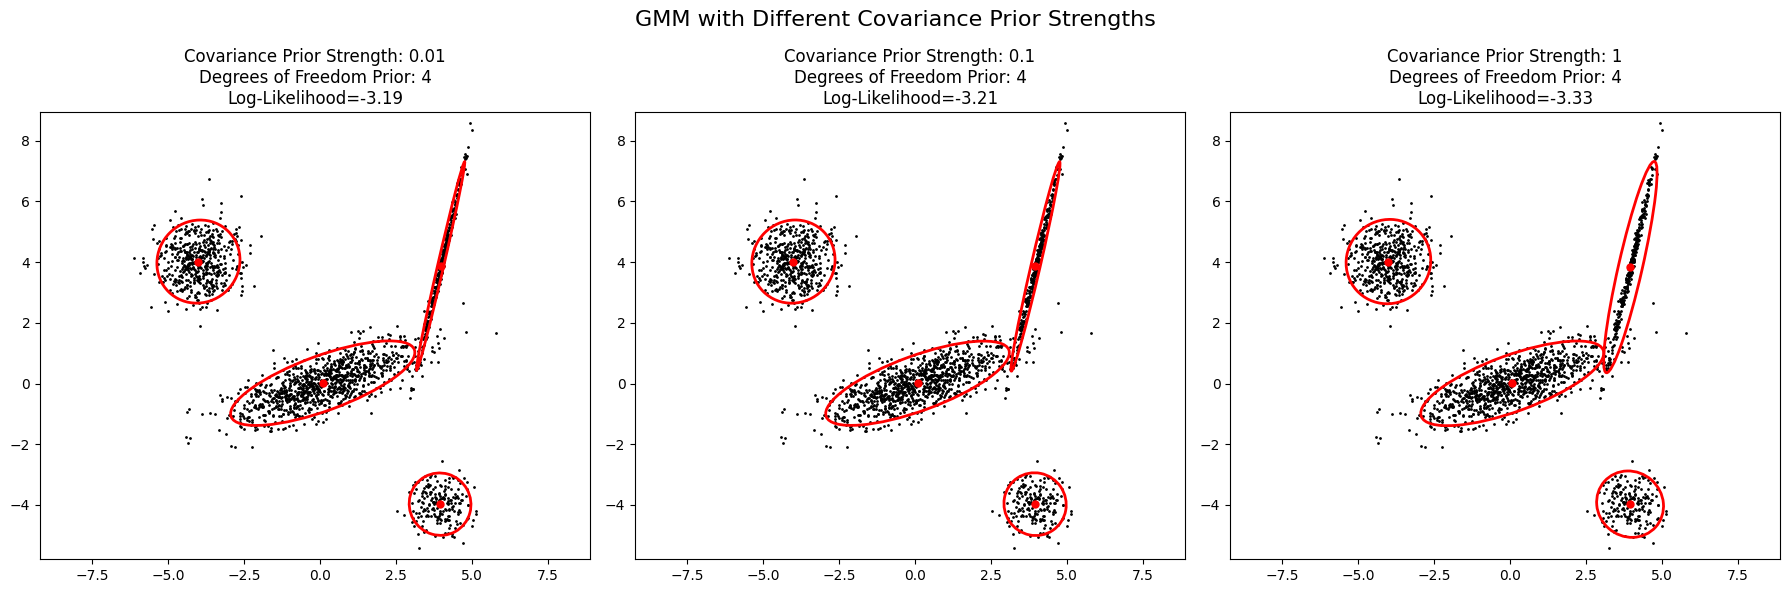

In [388]:
data_covariance = torch.tensor(np.cov(X_tensor.cpu().numpy(), rowvar=False), dtype=torch.float32)

covariance_prior_strengths = [.01, 0.1, 1]
degrees_of_freedom_prior = n_features + 2

mean_prior = initial_means.clone().detach().to(device)
mean_precision_prior = 1e-10

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('GMM with Different Covariance Prior Strengths', fontsize=16)

for ax, prior_strength in zip(axs.ravel(), covariance_prior_strengths):
    covariance_prior = data_covariance.unsqueeze(0).repeat(n_components, 1, 1) * prior_strength
    
    # Create the GMM with a prior on the covariances
    gmm_prior_covariances = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        init_params=init_params,
        mean_prior=mean_prior,
        mean_precision_prior=mean_precision_prior,
        degrees_of_freedom_prior=degrees_of_freedom_prior,
        covariance_prior=covariance_prior,
        random_state=random_state,
        device=device,
        verbose=False
    )
    
    # Fit the GMM to the data
    gmm_prior_covariances.fit(X_tensor)
    
    # Predict labels
    y_pred = gmm_prior_covariances.predict(X_tensor).cpu().numpy()
    
    # Plot the results
    plot_gmm(gmm_prior_covariances, X_tensor, y_pred, ax=ax,
             title=f'Covariance Prior Strength: {prior_strength}\nDegrees of Freedom Prior: {degrees_of_freedom_prior}\nLog-Likelihood={gmm_prior_covariances.lower_bound_:.2f}', color='red')
    
plt.tight_layout()
plt.savefig('figures/gmm_covariance_prior_strength.pdf', format='pdf', dpi = 400)
plt.show()


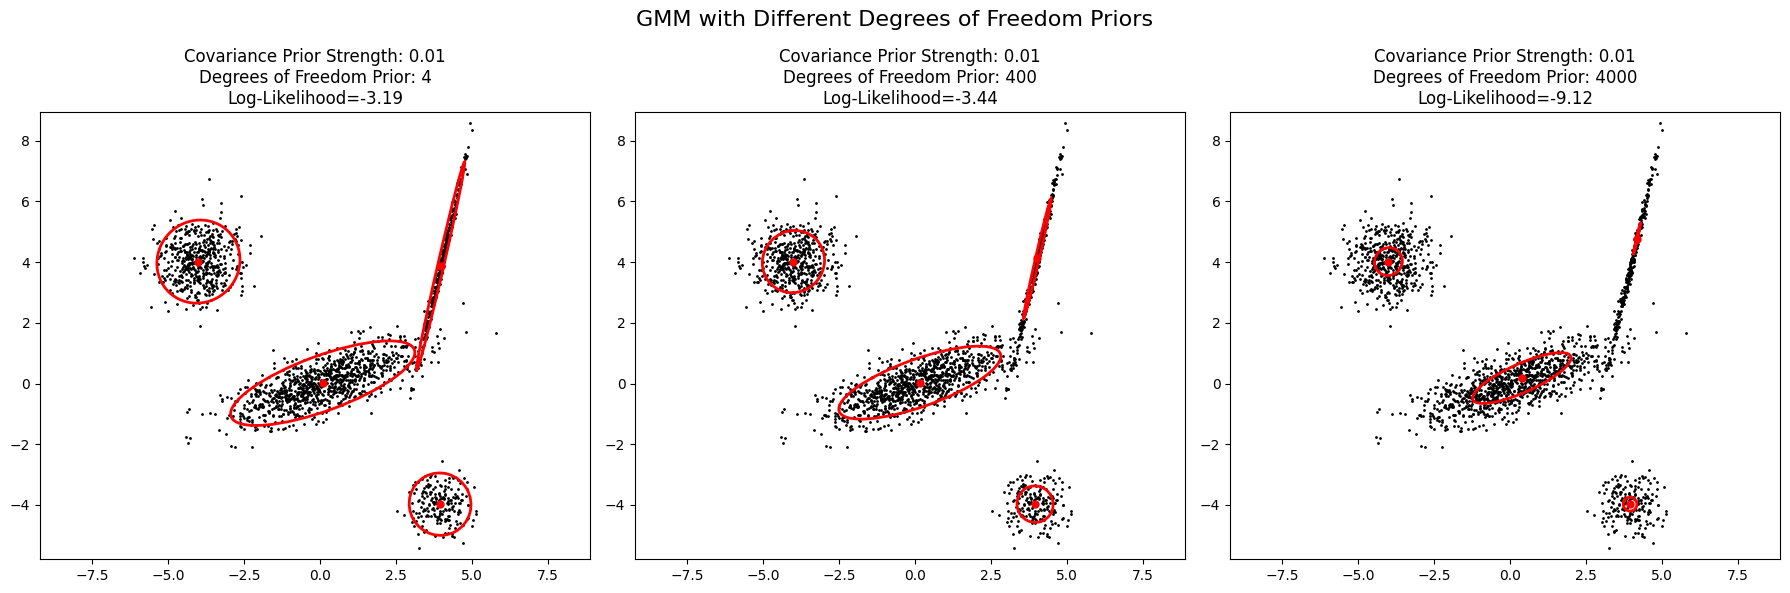

In [389]:
degrees_of_freedom = [4, 400, 4000]
prior_strength = 0.01
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('GMM with Different Degrees of Freedom Priors', fontsize=16)

for ax, degrees_of_freedom_prior in zip(axs.ravel(), degrees_of_freedom):
    covariance_prior = data_covariance.unsqueeze(0).repeat(n_components, 1, 1) * prior_strength

    
    # Create the GMM with a prior on the covariances
    gmm_prior_covariances = GaussianMixture(
        n_features=n_features,
        n_components=n_components,
        covariance_type='full',
        max_iter=max_iter,
        init_params=init_params,
        mean_prior=mean_prior,
        mean_precision_prior=mean_precision_prior,
        degrees_of_freedom_prior=degrees_of_freedom_prior,
        covariance_prior=covariance_prior,
        random_state=random_state,
        device=device,
        verbose=False
    )
    
    # Fit the GMM to the data
    gmm_prior_covariances.fit(X_tensor)
    
    # Predict labels
    y_pred = gmm_prior_covariances.predict(X_tensor).cpu().numpy()
    
    # Plot the results
    plot_gmm(gmm_prior_covariances, X_tensor, y_pred, ax=ax,
             title=f'Covariance Prior Strength: {prior_strength}\nDegrees of Freedom Prior: {degrees_of_freedom_prior}\nLog-Likelihood={gmm_prior_covariances.lower_bound_:.2f}', color='red')
    
plt.tight_layout()
plt.savefig('figures/gmm_covariance_prior_dof.pdf', format='pdf', dpi = 400)
plt.show()
